# 実習11 画像分類5（まとめ）

画像分類についてここまで実施してきた実習のまとめとして、5種類の花の画像（チューリップ、タンポポ、バラ、デイジー、ヒマワリ）を分類するAIを作成する。

また、AIのモデルとして、CNNを用いて自作したモデルと、転移学習を使用して作成したモデルの2つを作成する。

**ランタイムのタイプはGPUの方がいいと思います。**

## 1. データセットの準備（共通）
googleapiでダウンロード可能な花の画像データセット（[tgzファイル](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)）を使用する。


### 1-1. zipファイルのダウンロードと展開
URLなどを指定し、tf.keras.utils.get_fileを使用してダウンロードし展開する。tgzを展開するための引数として
untar=True, extract=Trueを指定する。
```
# tensorflowなどインポート
import tensorflow as tf
from tensorflow import keras

# ダウンロード元URL
_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

# get_fileを使用してtgzをダウンロードし展開
# ダウンロード先（subdir）は必要に応じて変更する
data_dir_name = 'flower_photos'
subdir = '/content/datasets'

data_dir = keras.utils.get_file(data_dir_name, origin=_URL, untar=True, extract=True, cache_subdir=subdir)

```


In [1]:
# tensorflowなどインポート
import tensorflow as tf
from tensorflow import keras

# ダウンロード元URL
_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

# get_fileを使用してtgzをダウンロードし展開
# ダウンロード先（subdir）は必要に応じて変更する
data_dir_name = 'flower_photos'
subdir = '/content/datasets'

data_dir = keras.utils.get_file(data_dir_name, origin=_URL, untar=True, extract=True, cache_subdir=subdir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


展開後のディレクトリ構成を確認しておくこと。

### 1-2. データセットの分割
今回のデータセットは、訓練用とテスト用に分かれていない。ImageDataGeneratorを使用するためには、データセットを分割して、適切なフォルダに入れる必要がある。

展開後のディレクトリ構成を以下のようにする場合を考える。
```
.
| - datasets
     | - flower_photos
           | - train
                | - daisy (画像フォルダ)
                | - dandelion（画像フォルダ）
                | - roses（画像フォルダ）
                | - sunflowers（画像フォルダ）
                | - tulips（画像フォルダ）
           | - validation
                (省略。trainと同じ)
```


実施手順は例の通りでなくてもいいが、訓練用データと検証用データを適切に振り分けること。

手順例
```
# 展開後のディレクトリ名から花の種類を調べる
import os
files = os.listdir(data_dir)
flower_list = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

# 分かりやすいところに、'train', 'validation'のフォルダを作成する
for dir in ['train','validation']:
  if not os.path.exists(os.path.join(data_dir, dir)):
    os.mkdir(os.path.join(data_dir, dir))

# validationフォルダの方にのみ、花の名前のディレクトリを作成する
for dir in flower_list:
  if not os.path.exists(os.path.join(data_dir,'validation',dir)):
    os.mkdir(os.path.join(data_dir,'validation',dir))

# 一部のデータをvalidationフォルダ内のサブフォルダに移動し、残りをフォルダごとtrainフォルダに移動する
import random
random.seed(学籍番号)
import shutil
VAL_SIZE = 0.2
for dir in flower_list:
  files = os.listdir(os.path.join(data_dir, dir)) #ファイルのリスト
  files_num = len(files) #ファイル数
  files_val = random.sample(files, int(files_num*VAL_SIZE)) #VAL_SIZEの割合だけファイル名をリスト
  # リストされたものだけを検証用に移動する
  for f in files_val:
    shutil.move(os.path.join(data_dir,dir,f), os.path.join(data_dir,'validation',dir))
  # 残りをフォルダごと訓練用に移動する
  shutil.move(os.path.join(data_dir,dir), os.path.join(data_dir,'train',dir))

```

In [2]:
import os
files = os.listdir(data_dir)
flower_list = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

# 分かりやすいところに、'train', 'validation'のフォルダを作成する
for dir in ['train','validation']:
  if not os.path.exists(os.path.join(data_dir, dir)):
    os.mkdir(os.path.join(data_dir, dir))

# validationフォルダの方にのみ、花の名前のディレクトリを作成する
for dir in flower_list:
  if not os.path.exists(os.path.join(data_dir,'validation',dir)):
    os.mkdir(os.path.join(data_dir,'validation',dir))

# 一部のデータをvalidationフォルダ内のサブフォルダに移動し、残りをフォルダごとtrainフォルダに移動する
import random
random.seed(2220042)
import shutil
VAL_SIZE = 0.2
for dir in flower_list:
  files = os.listdir(os.path.join(data_dir, dir)) #ファイルのリスト
  files_num = len(files) #ファイル数
  files_val = random.sample(files, int(files_num*VAL_SIZE)) #VAL_SIZEの割合だけファイル名をリスト
  # リストされたものだけを検証用に移動する
  for f in files_val:
    shutil.move(os.path.join(data_dir,dir,f), os.path.join(data_dir,'validation', dir,f)) # Specify destination filename
# 残りをフォルダごと訓練用に移動する
  shutil.move(os.path.join(data_dir,dir), os.path.join(data_dir,'train'))  # Move directory to 'train' folder

### 1-3. ImageDataGeneratorによるデータセットの作成
訓練用と検証用のImageDataGeneratorをセットアップする。
*   訓練用のジェネレータでのみ、実施する前処理を指定する。
*   前処理の有無や種類、パラメータなどは複数の値で検証してみること


In [46]:
# ImageDataGeneratorのセットアップ
from tensorflow.keras.preprocessing.image import ImageDataGenerator

次に、flow_from_directoryを使用し、画像のあるディレクトリ等を指定する。すると、データセットを自動的に作成する。

ヒントなど

*   ディレクトリを適切に指定する。os.path.joinなどを使用してもよい。
*   入力画像のサイズを決めておくこと
*   多値分類なので、class_mode='categorical' を指定する
*   seedには学籍番号を入れること


In [47]:
# 入力画像のサイズ（実行すること）
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [48]:
# 訓練用データの作成
train_img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data_it = train_img_gen.flow_from_directory(directory='/content/datasets/flower_photos/train',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           seed=2220042)

Found 2939 images belonging to 5 classes.


In [49]:
# 検証用データの作成
val_img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_data_it = val_img_gen.flow_from_directory(directory='/content/datasets/flower_photos/validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           seed=2220042)

Found 731 images belonging to 5 classes.


## 2. モデルの作成1：自作のCNN
Sequential()などを使用して、自分でCNNを構成する。<br>
**※学習にはかなり時間がかかる可能性がありますが、モデル構成の検討もできるだけ実施してください。**<br>
ヒントなど
*    5つのカテゴリに分類する問題であることに注意して出力層を決める
*    コンパイルでは、損失関数としてloss='categorical_crossentropy'を指定する

**[課題]モデルを作成し、summaryを表示してください。**

In [66]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Dropout

# モデル作成
model = keras.Sequential([
    Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(4),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(4,4),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

In [67]:
# summaryの表示
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,765 (1.62 MB)

 Trainable params: 425,765 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

過学習に気を付けて学習を行うこと。

In [69]:
# fitで学習しつつ検証
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hist = model.fit(train_data_it, validation_data=val_data_it, epochs=10)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 564ms/step - accuracy: 0.5611 - loss: 1.0522 - val_accuracy: 0.5431 - val_loss: 1.0634
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 489ms/step - accuracy: 0.5940 - loss: 0.9940 - val_accuracy: 0.6115 - val_loss: 0.9746
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 497ms/step - accuracy: 0.6403 - loss: 0.9524 - val_accuracy: 0.6484 - val_loss: 0.9420
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.6279 - loss: 0.9208 - val_accuracy: 0.6224 - val_loss: 0.9178
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 507ms/step - accuracy: 0.6461 - loss: 0.8839 - val_accuracy: 0.6676 - val_loss: 0.8917
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 512ms/step - accuracy: 0.6414 - loss: 0.8681 - val_accuracy: 0.6402 - val_loss: 0.9201
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 487ms/step - accuracy: 0.6769 - loss: 0.8096 - val_accuracy: 0.6676 - val_loss: 0.8688
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 514ms/step - accuracy: 0.6624 - loss: 0.8192 - val_accu

学習の過程と結果をグラフ化する

In [70]:
# このまま実行する
import matplotlib.pyplot as plt

# 後のために、グラフを表示する関数を作成しておく
def plot_graphs(hist, metric):

  # ----------------------------
  # 各epochでの誤差と精度を取得
  # ----------------------------
  met      = hist.history[     metric ]
  val_met  = hist.history[ 'val_'+metric ]
  loss     = hist.history[    'loss' ]
  val_loss = hist.history['val_loss' ]

  epochs   = range(len(met)) # Get number of epochs

  # ---------------------------------------------
  # エポック数に対する誤差を表示（片対数グラフ）
  # --------------------------------------------
  plt.plot  ( epochs,     loss, label='loss')
  plt.plot  ( epochs, val_loss, label='val_loss')
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.yscale('log')
  plt.figure()
  plt.show()

  # ------------------------------------------------
  # エポック数に対するメトリックの値を表示
  # ------------------------------------------------
  plt.plot  ( epochs,     met, label='met' )
  plt.plot  ( epochs, val_met, label='val_met')
  plt.title ('Training and validation metric value')
  plt.legend()
  plt.figure()
  plt.show()

**[課題]学習の過程と結果をグラフで表示する。**

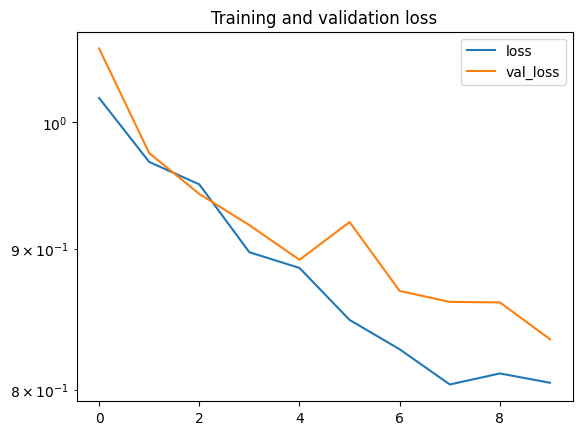

<Figure size 640x480 with 0 Axes>

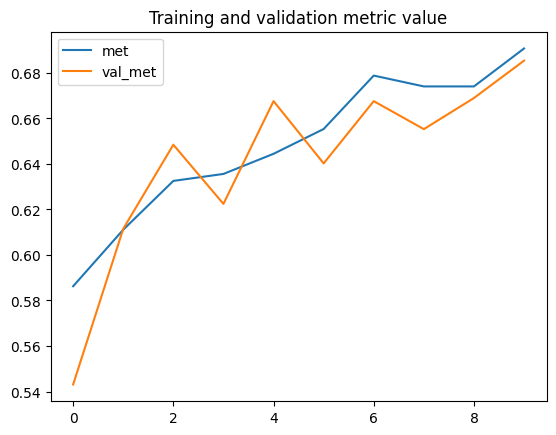

<Figure size 640x480 with 0 Axes>

In [71]:
# accuracyグラフ描画
plot_graphs(hist, 'accuracy')

手持ちのデータを入力してみて、予測結果を確認する。

（新しいデータを使用するか、validationフォルダ内のファイルを選んでもよい。）


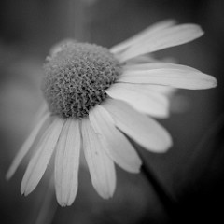

In [72]:
#読み込みと確認（画像のファイルパス要確認）
img = tf.keras.preprocessing.image.load_img(
    '/content/datasets/flower_photos/train/daisy/10437770546_8bb6f7bdd3_m.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img

In [73]:
#画像を配列に変換
img_array = tf.keras.preprocessing.image.img_to_array(img)
# 軸の追加（1枚の画像のため）
img_array = img_array[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array = img_array/255.0
# 予測
model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


array([[0.12611948, 0.7133248 , 0.10252322, 0.0088787 , 0.04915388]],
      dtype=float32)

In [74]:
# 予測結果（preとする）は配列で出てくるので、
# pre[0].argmax()で確率が最大のindexを出す
# それを変換表のリストの添え字として入れる
flower = list(train_data_it.class_indices.keys())
flower[model.predict(img_array)[0].argmax()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'dandelion'

## 3. モデルの作成2：転移学習の使用

### 3-1. ベースモデルの選択
転移学習に使用する元のモデル（ベースモデル）を選択する。

**【課題】選択したモデル：[　]**

### 3-2. ベースモデルを転移学習用に読み込み

選択したモデルを転移学習のために読み込む。
ImageNetで学習済みの重みを使用して転移学習をるためには、モデル作成時に引数としてweights='imagenet', include_top=Falseを指定する。

また、すべてのパラメータがTrainable（学習可能）になっているため、学習を不可にしておく。

可能であれば、元のモデルの形状も調べておいた方がいいかもしれない。（入力画像のサイズや追加する層の参考として）

In [75]:
#  MobileNetを使用するためにimport
from tensorflow.keras.applications.mobilenet import MobileNet
model2 = MobileNet(weights='imagenet', include_top=False)

<ipython-input-75-872e5f31fc51>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model2 = MobileNet(weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [76]:
#モデルの凍結
model2.trainable = False

In [77]:
# summaryの確認
model2.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, None, None, 32)      │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, None, None, 64)      │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, None, None, 64)      │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, None, None, 128)     │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, None, None, 128)     │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, None, None, 128)     │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [78]:
# 元のモデルの形状を確認してもよい
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,277,297 (4.87 MB)

 Trainable params: 425,765 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 851,532 (3.25 MB)

### 3-3. 新しいモデルの作成
上で作成したベースモデルに層を追加して新しいモデルを作成する。
（Functional APIでないと作れないかもしれない）

*  5つのカテゴリに分類する問題であることに注意して出力層を決める
*  コンパイルでは、損失関数としてloss='categorical_crossentropy'を指定する



In [79]:
# 短く書くためにインポート
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [86]:
# 新しいモデルの作成
# 入力層を作成する
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ベースモデルに層を追加する。
x = model2(inputs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Modelの引数として入力（inputs）と出力（outputs）を指定してモデルを作成する
model3 = Model(inputs=inputs, outputs=predictions)

In [87]:
# summaryを表示して確認
model3.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,652,165 (36.82 MB)

 Trainable params: 6,423,301 (24.50 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

### 3-4. 新しいデータで学習
作成したモデルを、学習させたいデータ（花の画像）で学習させつつ、検証用データで精度を確認する。


In [88]:
#モデルのコンパイル
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
# fitで学習しつつ検証
hist2 = model3.fit(train_data_it, validation_data=val_data_it, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 586ms/step - accuracy: 0.5923 - loss: 5.1321 - val_accuracy: 0.8044 - val_loss: 0.5757
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 504ms/step - accuracy: 0.8489 - loss: 0.4417 - val_accuracy: 0.8399 - val_loss: 0.4997
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 513ms/step - accuracy: 0.8491 - loss: 0.4275 - val_accuracy: 0.8358 - val_loss: 0.4575
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - accuracy: 0.8753 - loss: 0.3588 - val_accuracy: 0.8509 - val_loss: 0.6019
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.8849 - loss: 0.3180 - val_accuracy: 0.8632 - val_loss: 0.4596


**[課題]学習の過程と結果をグラフで表示する。**

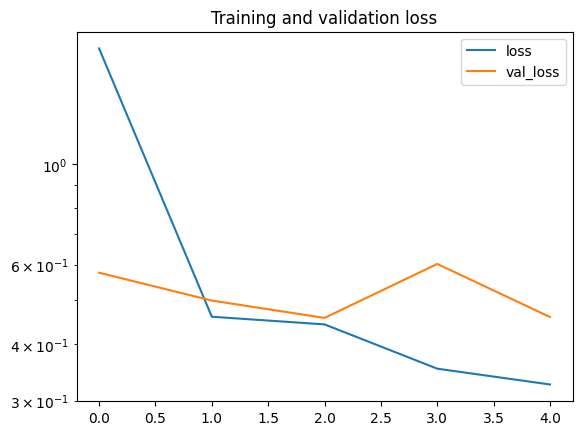

<Figure size 640x480 with 0 Axes>

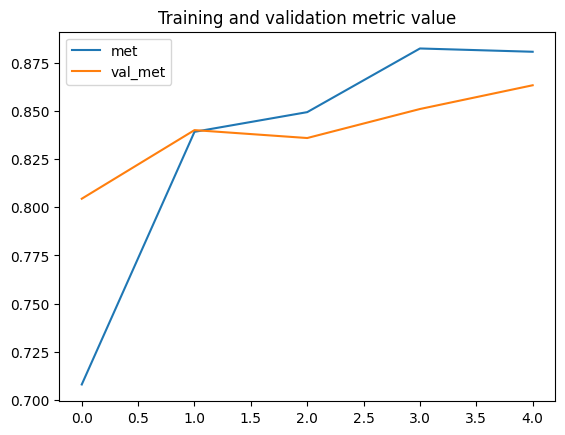

<Figure size 640x480 with 0 Axes>

In [101]:
# accuracyグラフの描画
plot_graphs(hist2, 'accuracy')

手持ちのデータを入力してみて、予測結果を確認する。

（新しいデータを使用するか、validationフォルダ内のファイルを選んでもよい。）

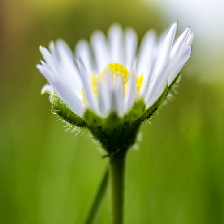

In [92]:
#読み込みと確認
img1 = keras.preprocessing.image.load_img(
    '/content/datasets/flower_photos/train/daisy/10841136265_af473efc60.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img1

In [98]:
# 画像を配列に変換
img_array = keras.preprocessing.image.img_to_array(img1)
# 軸の追加（1枚の画像のため）
img_array = img_array[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array = img_array/255.0
# 予測
pred = model.predict(img_array).round().astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [100]:
# 予測結果（preとする）は配列で出てくるので、
# pre[0].argmax()で確率が最大のindexを出す
# それを変換表のリストの添え字として入れる
# 変換リストの作成
list(train_data_it.class_indices.keys())

# リスト名[0か1]
list(train_data_it.class_indices.keys())[pred[0].argmax()]

'daisy'

# 提出について

実習が終わったら、以下をチェックしてもらうこと。

*   自作モデルのSummary
*   自作モデルの学習状況グラフ
*   転移学習のベースモデル
*   転移学習の学習状況グラフ

その後、このファイルをipynbでダウンロードして提出してください。（ファイル名にクラス番号氏名を入れること。）
